# Getting Started

This notebook illustrates how to get started using PySOC.

To install PySOC, in the command line run:

```bash
pip install git+https://github.com/codekansas/soc
```

The example below will illustrate how to use PySOC to visualize the top question-answer pairs in the subreddit [/r/AskReddit](https://www.reddit.com/r/AskReddit/).

To download the appropriate data, use the command-line tool. This requires installing `[praw](https://praw.readthedocs.io/en/latest/)` and putting the right [credentials](https://praw.readthedocs.io/en/latest/getting_started/authentication.html#oauth) in the environment.

```bash
>>> pip install praw
>>> export praw_client_id=<CLIENT_ID>
>>> export praw_client_secret=<CLIENT_SECRET>
>>> export praw_user_agent=<USER_AGENT>
```

To use the command-line interface, run

```bash
>>> pysoc ask_reddit download --help
Usage: pysoc ask_reddit download [OPTIONS]

Options:
  --fname TEXT
  --num_results INTEGER
  --override TEXT
  --num_comments INTEGER
  --time_filter [hour|day|week|month|year|all]
  --wait_time FLOAT
  -h, --help                      Show this message and exit.
```

To download 100 results, with the top 5 comments from each result, run:

```bash
>>> pysoc ask_reddit download --num_results 100 --num_comments 5
```

In [1]:
from __future__ import print_function

import numpy as np
from soc.modules import AskReddit

# Instantiate a new instance.
ask_reddit = AskReddit(one_hot_input=False, one_hot_output=True)

# Prints the expected shape before loading the dataset.
print('Before:')
(input_shape,), (output_shape,) = ask_reddit.shape
print('  input shape:', input_shape, '--',
      'output shape:', output_shape)

# The shape will be different after loading the data,
# because the character dictionaries have changed.
print('\nAfter:')
(questions,), (answers,) = ask_reddit.train_data
print('  input batch shape:', questions.shape, '--',
      'output batch shape:', answers.shape)
(input_shape,), (output_shape,) = ask_reddit.shape
print('  input shape:', input_shape, '--',
      'output shape:', output_shape)

# Shows some samples from the data.
question_strings = ask_reddit.decode(questions, argmax=False)
answer_strings = ask_reddit.decode(answers, argmax=True)
for i in range(5):
    print(question_strings[i], '--', answer_strings[i])

Before:
  input shape: (100,) -- output shape: (100, 1)

After:
  input batch shape: (100, 100) -- output batch shape: (100, 100, 1661)
  input shape: (100,) -- output shape: (100, 1661)
What bot accounts on reddit should people know about ? -- Every account on reddit is a bot except you .
What bot accounts on reddit should people know about ? -- Every account on reddit is a bot except you .
What bot accounts on reddit should people know about ? -- Every account on reddit is a bot except you .
What bot accounts on reddit should people know about ? -- Every account on reddit is a bot except you .
What bot accounts on reddit should people know about ? -- Every account on reddit is a bot except you .


The example below shows a histogram of the words in the questions.

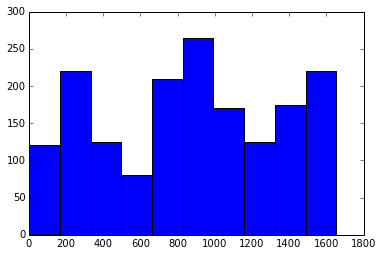

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

question_idxs = [i for i in questions.reshape(-1) if i > 0]
_ = plt.hist(question_idxs)

The example below show how to use the model in a Keras model. This is a short proof-of-concept example, but could be run for a longer amount of time to try to get realistic-looking predictions.

In [ ]:
import keras
import numpy as np

num_embed_dims = 32
samples_per_epoch = 64
nb_epoch = 5
batch_size = 8

input_var = keras.layers.Input(input_shape)
x = keras.layers.Embedding(ask_reddit.num_chars, num_embed_dims)(input_var)
x = keras.layers.LSTM(64)(x)
x = keras.layers.RepeatVector(100)(x)
x = keras.layers.LSTM(64, return_sequences=True)(x)
x = keras.layers.TimeDistributed(keras.layers.Dense(ask_reddit.num_chars))(x)

model = keras.models.Model([input_var], [x])
model.compile(loss='categorical_crossentropy', optimizer='nadam')
_ = model.fit_generator(ask_reddit.iterate_data(batch_size), samples_per_epoch, nb_epoch)

# Prints predictions from the model.
print('\nPredictions:')
pred_answers = model.predict([questions])
question_strings = ask_reddit.decode(questions, argmax=False)
answer_strings = ask_reddit.decode(pred_answers, argmax=True)
for i in np.random.choice(len(question_strings), 5):
    print(question_strings[i], '--', answer_strings[i])